In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from keras import layers, models
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score



In [24]:
pic=plt.imread("C:\Users\ahmed\Desktop\Supcom\stage ingenieur\distraction_detector\STAGE\PART_3\Distraction_database\train\c0\100361.jpg")
plt.imshow(pic, cmap="gray")
print(pic.shape)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2037375348.py, line 1)

In [20]:
DataDirectory = 'C:\Users\ahmed\Desktop\Supcom\stage ingenieur\distraction_detector\STAGE\PART_3\Distraction_database\train'
TestDirectory= '\Distraction_database\test'
Classes = ['c0','c1','c2','c3','c4','c5','c6']
img_size = 120

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (831821134.py, line 1)

In [21]:
import concurrent.futures

def preprocess_image(image_path, img_size):
    img_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    desired_size = (img_size, img_size)
    height, width = img_array.shape
    aspect_ratio = width / height

    if aspect_ratio >= 1:
        new_width = desired_size[0]
        new_height = int(new_width / aspect_ratio)
    else:
        new_height = desired_size[1]
        new_width = int(new_height * aspect_ratio)

    resized_image = cv2.resize(img_array, (new_width, new_height))

    pad_width = (desired_size[1] - new_height) // 2
    pad_height = (desired_size[0] - new_width) // 2
    padded_image = np.pad(resized_image, ((pad_width, pad_width), (pad_height, pad_height)), mode='constant', constant_values=0)

    rgb_image = cv2.cvtColor(padded_image, cv2.COLOR_GRAY2RGB)

    return rgb_image

def create_training_data(Classes, Datadirectory, img_size, max_images_per_class=1900):
    training_data = []
    
    with concurrent.futures.ThreadPoolExecutor() as executor:  # Use ThreadPoolExecutor for concurrent threads
        futures = []

        for class_num, category in enumerate(Classes):
            path = os.path.join(Datadirectory, category)
            image_count = 0  # Initialize a counter for images in the class

            for img in os.listdir(path):
                if image_count >= max_images_per_class:
                    break
                
                img_path = os.path.join(path, img)
                futures.append(executor.submit(preprocess_image, img_path, img_size))
                
                training_data.append([futures[-1].result(), class_num])
                image_count += 1

    print("Data processing completed.")
    return training_data


In [22]:
import concurrent.futures

def preprocess_image(image_path, img_size):
    img_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    desired_size = (img_size, img_size)
    height, width = img_array.shape
    aspect_ratio = width / height

    if aspect_ratio >= 1:
        new_width = desired_size[0]
        new_height = int(new_width / aspect_ratio)
    else:
        new_height = desired_size[1]
        new_width = int(new_height * aspect_ratio)

    resized_image = cv2.resize(img_array, (new_width, new_height))

    pad_width = (desired_size[1] - new_height) // 2
    pad_height = (desired_size[0] - new_width) // 2
    padded_image = np.pad(resized_image, ((pad_width, pad_width), (pad_height, pad_height)), mode='constant', constant_values=0)

    rgb_image = cv2.cvtColor(padded_image, cv2.COLOR_GRAY2RGB)

    return rgb_image

def create_testing_data(TestDirectory, img_size, max_images=80000000):
    testing_data = []
    path = os.path.join(TestDirectory, '')
    count = 0

    with concurrent.futures.ThreadPoolExecutor() as executor:  # Use ThreadPoolExecutor for concurrent threads
        futures = []

        for img in os.listdir(path):
            if count >= max_images:
                break
            
            img_path = os.path.join(path, img)
            futures.append(executor.submit(preprocess_image, img_path, img_size))
            count += 1

        for future in concurrent.futures.as_completed(futures):
            testing_data.append([future.result()])

    print("Data processing completed.")
    return testing_data


In [23]:
training_data= create_training_data(Classes, DataDirectory, img_size)

OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: '\\Distraction_database\train\\c0'

In [ ]:
testing_data= create_training_data(Classes,TestDirectory, img_size)

Data processing completed.


In [ ]:
random.shuffle(training_data)

In [ ]:
print(len(training_data))
print(len(testing_data))

15000
79726


In [ ]:
X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 3)
Y=np.array(y)


In [ ]:
print(len(Y),len(X))
print(training_data[10000][1])

15000 15000
3


# Builidng the model

In [ ]:
# Define the input shape
input_shape = (240, 240, 3)
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(384, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output from Conv2D layers
model.add(layers.Flatten())

# Add fully connected layers with specified parameters
model.add(layers.Dense(8192, activation='relu'))
model.add(layers.Dense(180, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10,activation='softmax'))

In [ ]:
# Define the input shape
input_shape = (120, 120, 3)
model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())  # Add batch normalization
model.add(layers.Dropout(0.5))  # Add dropout for regularization
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 59, 59, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 64)      

In [ ]:
from keras.utils import to_categorical

model.compile(loss="binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=4, mode='max', verbose=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

Y_train = to_categorical(Y_train,num_classes=10)
Y_val = to_categorical(Y_val,num_classes=10)

In [ ]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping_callback])

Epoch 1/20
375/375 [==============================] - 14s 9ms/step - loss: 0.5677 - accuracy: 0.2171 - val_loss: 0.4793 - val_accuracy: 0.2020
Epoch 2/20
375/375 [==============================] - 3s 7ms/step - loss: 0.2798 - accuracy: 0.4131 - val_loss: 0.2519 - val_accuracy: 0.4740
Epoch 3/20
375/375 [==============================] - 3s 7ms/step - loss: 0.2004 - accuracy: 0.6472 - val_loss: 0.1645 - val_accuracy: 0.6963
Epoch 4/20
375/375 [==============================] - 3s 7ms/step - loss: 0.1478 - accuracy: 0.7804 - val_loss: 0.2045 - val_accuracy: 0.5820
Epoch 5/20
375/375 [==============================] - 3s 7ms/step - loss: 0.1193 - accuracy: 0.8354 - val_loss: 0.0716 - val_accuracy: 0.9063
Epoch 6/20
375/375 [==============================] - 3s 7ms/step - loss: 0.0957 - accuracy: 0.8773 - val_loss: 0.1282 - val_accuracy: 0.8810
Epoch 7/20
375/375 [==============================] - 3s 7ms/step - loss: 0.0800 - accuracy: 0.9040 - val_loss: 0.0662 - val_accuracy: 0.9023
Epoch

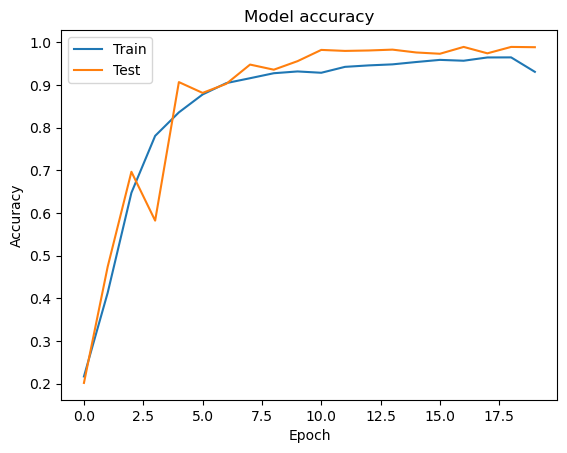

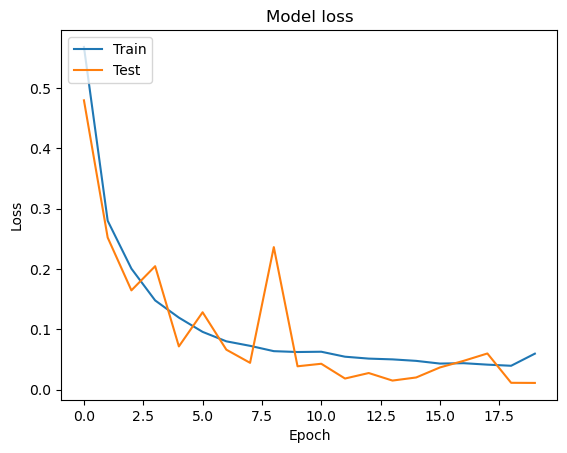

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

###  Testing

In [ ]:
X_test = []
X_test=testing_data

#Y_test=np.array(y_test)

In [ ]:
X_test = np.array(X_test).reshape(-1, img_size, img_size, 3)

# Divide the test dataset into smaller parts (e.g., 10 parts)
num_parts = 10
part_size = len(X_test) // num_parts

# Initialize an empty list to store the predictions
all_predictions = []

# Loop through each part and make predictions
for i in range(num_parts):
    start_idx = i * part_size
    end_idx = (i + 1) * part_size
    part_predictions = model.predict(X_test[start_idx:end_idx])
    all_predictions.append(part_predictions)

# Concatenate all the predictions into a single array
all_predictions = np.concatenate(all_predictions, axis=0)




In [ ]:
# Create a DataFrame from the concatenated predictions
Pred = pd.DataFrame(all_predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
Pred.head()

In [ ]:
sample_sub = pd.read_csv("/kaggle/input/state-farm-distracted-driver-detection/sample_submission.csv")
sample_sub.head()

In [ ]:
img = pd.read_csv("/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv")
img=img['img']
img.head(20)

In [ ]:
Pred = pd.DataFrame(predictions, columns = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'])
Pred.head()

In [ ]:
sub = pd.concat((img, Pred), axis = 1)
sub=sub*10
sub.head()

In [ ]:
sub[['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']].to_csv(r'/kaggle/working/sub0.csv', index=False)

In [ ]:
"""# Make predictions on testing data
predictions = model.predict(X_test)

# Analyze predictions
for i, prediction in enumerate(predictions):
    predicted_class = np.argmax(prediction)  # Get the index of the predicted class
    #print(f"Image {i+1}: Predicted Class: {predicted_class}")"""